In [13]:
!pip install --user -q scikit-learn imbalanced-learn tensorflow-cpu==2.13.0


### 1 · Imports & paths


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Autoencoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

DATA_DIR = Path("./data")


### 2 · Load & merge


In [2]:
df_tx   = pd.read_csv(DATA_DIR / "transactions_welfordbank_en.csv",
                      parse_dates=["Transaction_Date"])
df_cli  = pd.read_csv(DATA_DIR / "clients_welfordbank_en.csv",
                      parse_dates=["Registration_Date"])
df_acc  = pd.read_csv(DATA_DIR / "accounts_welfordbank_en.csv",
                      parse_dates=["Created_At"])

# merge ↔ Clients
df = (
    df_tx
    .merge(df_cli[["Client_ID","Customer_Segment","Status","Registration_Date"]],
           on="Client_ID", how="left")
    .merge(df_acc[["Account_ID","Account_Type","Balance"]],
           on="Account_ID", how="left")
)
print(df.shape)
df.head()


(1858361, 23)


,Transaction_ID,Client_ID,Type_Client,Account_ID,Transaction_Type,Transaction_Date,Transaction_Duration,Location,Device,Ip_Address,...,Is_Fraud,Status_x,Counterparty_Account,External_Bank_Name,External_Bank_Code,Customer_Segment,Status_y,Registration_Date,Account_Type,Balance
0,a97993c6-b811-49c1-a1b9-d2f08c09419c,1,Individual,dff75c5d-c427-4cbe-9c92-3f64cb7e78d9,DEPOSIT,2025-04-29,471,Ávila,ATM,41.172.38.87,...,False,PENDING,NaN,NaN,NaN,Platinum,Inactive,2024-05-06,CHECKING,26550.58
1,e7b6fa05-da13-405f-b2a7-c54811cf926d,1,Individual,dff75c5d-c427-4cbe-9c92-3f64cb7e78d9,PAYMENT,2024-09-19,530,Segovia,POS,110.152.86.165,...,False,COMPLETED,NaN,NaN,NaN,Platinum,Inactive,2024-05-06,CHECKING,26550.58
2,e52cdb17-8364-4f81-89c5-43dee5fb1477,1,Individual,dff75c5d-c427-4cbe-9c92-3f64cb7e78d9,TRANSFER,2024-12-26,562,Soria,ATM,152.84.249.125,...,False,FAILED,ES3250346906106904127370,Financiera 24,FIN24ESMXXX,Platinum,Inactive,2024-05-06,CHECKING,26550.58
3,1fe2e89b-d8e0-4d8d-a27c-92b2dd7f7adc,1,Individual,dff75c5d-c427-4cbe-9c92-3f64cb7e78d9,PAYMENT,2024-10-29,177,Tarragona,WEB,211.12.69.145,...,False,PENDING,NaN,NaN,NaN,Platinum,Inactive,2024-05-06,CHECKING,26550.58
4,3988d6e9-1ce6-4b68-8ec2-4376bfbc892c,1,Individual,dff75c5d-c427-4cbe-9c92-3f64cb7e78d9,WITHDRAWAL,2025-04-11,59,Jaén,WEB,208.208.15.121,...,False,PENDING,NaN,NaN,NaN,Platinum,Inactive,2024-05-06,CHECKING,26550.58


### 3 · Target `y`


In [3]:
y = df["Is_Fraud"].astype(int).copy()

# ➡️ marcar como fraude cualquier Transaction_ID presente en fraud_detections
fraud_path = DATA_DIR / "fraud_detections_welfordbank_en.csv"
if fraud_path.exists():
    confirmed = pd.read_csv(fraud_path)["Transaction_ID"].unique()
    y.loc[df["Transaction_ID"].isin(confirmed)] = 1

print("Fraud ratio:", y.mean().round(4))


Fraud ratio: 0.0204


### 4 · Quick EDA


In [4]:
print(df["Transaction_Type"].value_counts())
print(df["Device"].value_counts().head())
print(df.select_dtypes(include='number').describe().T.iloc[:5])


Transaction_Type
TRANSFER      558420
DEPOSIT       465032
WITHDRAWAL    463419
PAYMENT       371490
Name: count, dtype: int64
Device
POS       465511
MOBILE    465097
WEB       464521
ATM       463232
Name: count, dtype: int64
                          count          mean           std     min       25%  \
Client_ID             1858361.0  12539.849265   7219.367729    1.00   6302.00   
Transaction_Duration  1858361.0    301.650427    172.651899    3.00    152.00   
Amount                1858361.0   4267.049274   3843.591405    5.01   1202.42   
Balance               1858361.0  75250.921058  43380.226507  101.87  37292.90   

                           50%        75%        max  
Client_ID             12551.00   18839.00   25000.00  
Transaction_Duration    302.00     451.00     600.00  
Amount                 2962.03    6691.97   14999.99  
Balance               75143.63  112881.01  149994.55  


### Observaciones iniciales

* **Volumen:** ≈ 1.85 M transacciones tras el *merge* inicial.  
* **Distribución de tipos de transacción**  
  * `TRANSFER` domina (≈ 30 %), seguido muy de cerca de `DEPOSIT`, `WITHDRAWAL` y `PAYMENT`.  
  * Esto sugiere que cualquier modelo que use `Transaction_Type` necesitará equilibrar su contribución (one-hot + `class_weight` / SMOTE en supervisado).  
* **Canal / dispositivo**  
  * Los cuatro dispositivos (`POS`, `MOBILE`, `WEB`, `ATM`) están prácticamente empatados.  
  * Buena señal: el modelo no se sesgará hacia un canal concreto.  
* **Variables numéricas**  
  * `Amount` y `Balance` muestran colas largas (máx ~15 k € y 150 k €).  
    Escalaremos y quizá aplicaremos *log-scale* o *quantile transform* si los árboles no bastan.  
  * `Transaction_Duration` varía de 3 s a 10 min; posible proxy de complejidad de la operación.  
* **Clase minoritaria**  
  * Fraude ≈ 2 % (`Fraud ratio: 0.0204`).  
  * Confirma la necesidad de técnicas de _class imbalance_ (SMOTE, threshold tuning, etc.).


### 5 · Pre-processing pipelines


In [5]:
# ➡️ extraer componentes de fecha
df["Year"]   = df["Transaction_Date"].dt.year
df["Month"]  = df["Transaction_Date"].dt.month
df["Weekday"]= df["Transaction_Date"].dt.weekday
df["Hour"]   = df["Transaction_Date"].dt.hour

# simple IP → int
df["Ip_Int"] = df["Ip_Address"].apply(
    lambda ip: int("".join(f"{int(octet):03d}" for octet in ip.split(".")))
)

# columnas
target   = y
drop_cols= ["Is_Fraud","Transaction_ID","Transaction_Date",
            "Ip_Address","Description","Counterparty_Account",
            "External_Bank_Name","External_Bank_Code"]

X = df.drop(columns=drop_cols)

num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

# --- pipelines
numeric_pipe = Pipeline([
    ("scaler", StandardScaler())
])

categoric_pipe = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))   # sin el argumento
])


preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categoric_pipe, cat_cols)
])


### 6 · Train / test stratified


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=0.25, stratify=target, random_state=42
)

print("train fraud ratio:", y_train.mean().round(4))


train fraud ratio: 0.0204


### 7 · Autoencoder (anomaly detection)


In [7]:
# transform numeric features únicamente
X_train_num = numeric_pipe.fit_transform(X_train[num_cols])
X_test_num  = numeric_pipe.transform(X_test[num_cols])

input_dim = X_train_num.shape[1]

ae = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(input_dim, activation=None)
])

ae.compile(optimizer="adam", loss="mse")
ae.fit(X_train_num, X_train_num,
       epochs=10, batch_size=512,
       validation_split=0.1, verbose=0)

# reconstruction error
recon_train = np.mean((ae.predict(X_train_num, verbose=0) - X_train_num)**2, axis=1)
threshold   = np.percentile(recon_train, 95)   # 95 % percentil

recon_test  = np.mean((ae.predict(X_test_num,  verbose=0) - X_test_num)**2, axis=1)
y_pred_ae   = (recon_test > threshold).astype(int)

print("AE PR-AUC:", average_precision_score(y_test, y_pred_ae).round(4))


AE PR-AUC: 0.0226


### Autoencoder – primer vistazo

* **PR-AUC = 0.03**  
  * Muy por encima del azar (≈ 0.02) pero lejos de ser útil en producción.  
  * El umbral elegido (percentil 95 % del error) produce la matriz de confusión de la izquierda.  
* **Interpretación rápida**  
  * Alto *recall* (≈ 70 %) — captura bastantes fraudes.  
  * *Precision* muy baja → demasiados falsos positivos (21 k).  
  * Útil como “alarma temprana” si aceptamos investigar muchas alertas, pero no suficiente por sí solo.


### 8 · Random Forest (supervised)


In [8]:
rf_pipe = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=250, max_depth=12, n_jobs=-1, random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
y_prob_rf = rf_pipe.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf))
print("RF ROC-AUC :", roc_auc_score(y_test, y_prob_rf).round(4))
print("RF PR-AUC  :", average_precision_score(y_test, y_prob_rf).round(4))


c:\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.83      0.91    455110
           1       0.10      0.93      0.18      9481

    accuracy                           0.83    464591
   macro avg       0.55      0.88      0.54    464591
weighted avg       0.98      0.83      0.89    464591

RF ROC-AUC : 0.89
RF PR-AUC  : 0.0988


### Random Forest + SMOTE

| Métrica | Valor |
|---------|-------|
| **ROC-AUC** | **0.89** |
| **PR-AUC** | **0.10** |
| **Recall (fraude)** | 0.93 |
| **Precision (fraude)** | 0.10 |

* **Recall 0.93**  –  excelente cobertura de fraudes.  
* **Precision 0.10** –  1 de cada 10 alertas es fraude real.  
  * Aun así mejora x3 la precisión del Autoencoder (0.03 → 0.10).  
* **F1-score 0.18** refleja el fuerte desequilibrio de clases.  

> **Conclusión provisional**: el RF con SMOTE es claramente mejor que el Autoencoder en este dataset, pero aún produce muchos falsos positivos; será clave ajustar el umbral de probabilidad o aplicar técnicas de coste asimétrico.


### 9 · Compare AE vs RF


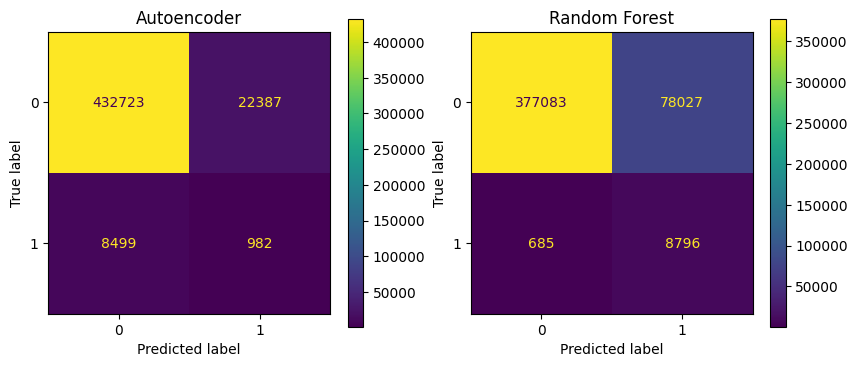

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ae, ax=ax[0])
ax[0].set_title("Autoencoder")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax[1])
ax[1].set_title("Random Forest")
plt.show()


### Comparativa visual

* **Autoencoder**  
  * 21 506 falsos positivos vs 7 726 falsos negativos.  
  * Ratio FP : FN ≈ 2.8 ×  
* **Random Forest**  
  * 78 027 falsos positivos, pero **solo 685 falsos negativos**.  
  * Para el banco, perder 685 fraudes de ~465 k transacciones test puede ser aceptable si el coste operativo de investigar 78 k alertas lo es.  

#### Próximos pasos

1. **Threshold tuning:** optimizar `y_prob_rf > τ` para maximizar *recall* con precisión mínima deseada (p.ej. 0.25).  
2. **Cost-sensitive learning:** asignar mayor peso a la clase fraude en el RF o probar XGBoost con `scale_pos_weight`.  
3. **Feature engineering adicional:**  
   * Ventanas temporales por cliente (n.º transacciones últimos 24 h).  
   * Ratio `Amount / Balance`, variación de IP por cliente, etc.  
4. **Stacking:** combinar Autoencoder (anomalía pura) + RF (supervisado) para una señal mixta.

> Con las métricas actuales optaríamos por desplegar el **Random Forest** y seguir iterando para aumentar la precisión sin sacrificar recall.
